# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In [207]:
import cv2
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [208]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, draw_fn=draw_lines):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_fn(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



In [209]:
image_dir = "images/source/" 

canny_params = {'low': 60, 'high': 150}
hough_params = {'threshold': 30, 'min_line_length': 20, 'max_line_gap': 30}

clip_region = np.array([[0, 1.0], [0.45, 0.6], [0.55, 0.6], [1, 1.0]])

def clip_to_region(image):
    height, width = image.shape[0:2]
    clip_points = (clip_region * [width, height]).astype(np.int32)
    return region_of_interest(image, [clip_points])

def grayscale_with_yellow_enhanced(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, np.array([20, 0, 200]), np.array([40, 255, 255]))

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.bitwise_or(gray, mask)

def detection_pipeline(image, draw_fn=draw_lines):
    gray = gaussian_blur(grayscale_with_yellow_enhanced(image), 7)
    
    edges = canny(gray, canny_params['low'], canny_params['high'])
    edges_clipped = clip_to_region(edges)

    line_img = hough_lines(edges_clipped, 1, math.pi / 180, 
                           hough_params['threshold'], 
                           hough_params['min_line_length'], 
                           hough_params['max_line_gap'], draw_fn=draw_fn)
    annotated_img = weighted_img(clip_to_region(line_img), image)    
    
    return (gray, edges, edges_clipped, line_img, annotated_img)

def draw_detected_lanes(image, draw_fn=draw_lines):
    results = detection_pipeline(image, draw_fn)
    return results[-1]

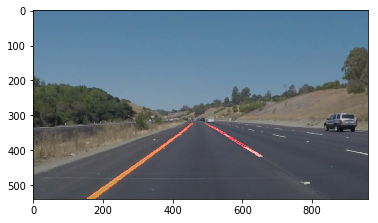

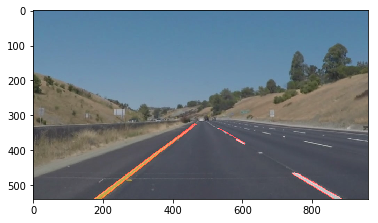

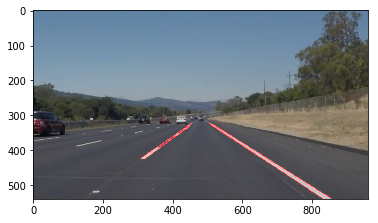

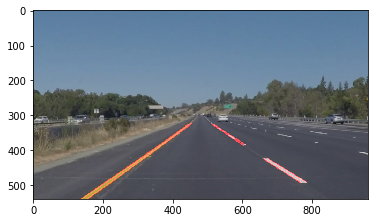

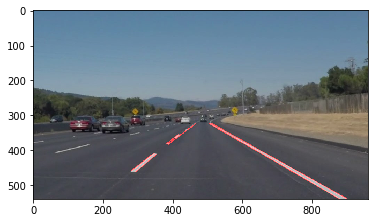

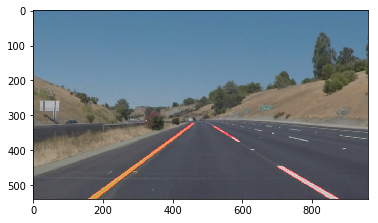

In [210]:
for image_file in os.listdir(image_dir):
    source = mpimg.imread(image_dir + image_file)
    annotated = draw_detected_lanes(source)
    
    plt.imshow(annotated)
    plt.show()

In [211]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clips = ['solidWhiteRight.mp4', 'solidYellowLeft.mp4']

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def read_source_clip(filename):
    return VideoFileClip('videos/source/' + filename)

def write_output_clip(video_clip, filename):
    video_clip.write_videofile('videos/out/' + filename, audio=False, verbose=False)

## Draw the detected lanes as a set of lines

In [212]:
for clip in clips:
    source = read_source_clip(clip)
    annotated = source.fl_image(draw_detected_lanes) 
    write_output_clip(annotated, 'annotated_' + clip)


100%|█████████▉| 681/682 [00:50<00:00, 13.39it/s]

In [213]:
display_video('videos/out/annotated_solidWhiteRight.mp4')

In [214]:
display_video('videos/out/annotated_solidYellowLeft.mp4')

## Draw lanes as straight lines

As a second part of the project, I take the series of lines detected in the videos, and derive the parameters of 2 lines that constitute left and right lane, respectively. This is done by averaging the parameters (slope and intercept) for each segment detected in the image. In order to avoid noise, I filter out the segments that don't belong to the lane: the segments that are too close to horizontal or vertial axes.

When the result lines are drawn over the image, they are clipped to the region of interest that was originally used to detect lanes.

In [215]:
slope_limits = [math.tan(math.pi / 8),
                math.tan(3 * math.pi / 8)]

def valid_slope(slope):
    abs_value = np.abs(slope)
    return (abs_value > slope_limits[0]) and (abs_value < slope_limits[1])

valid_slope = np.vectorize(valid_slope)

def line_params(point_coords):
    x1, y1, x2, y2 = point_coords
    slope = float(y2-y1) / (x2 - x1)
    intercept = y1 - (slope * x1)
    return (slope, intercept)

def average_lane_params(lines):
    lines = lines.reshape(-1, 4)
    params = np.apply_along_axis(line_params, 1, lines)
    slopes = params[:, 0]
    
    left_lane = params[(slopes < 0) & valid_slope(slopes)].mean(axis=0)
    right_lane = params[(slopes > 0) & valid_slope(slopes)].mean(axis=0)
    return (left_lane, right_lane)

def draw_line_with_params(img, line_params, color=[255, 0, 0], thickness=8):
    slope, intercept = line_params
    xmax = img.shape[1]
    p1 = (0, int(intercept))
    p2 = (xmax, int(slope * xmax + intercept))
    cv2.line(img, p1, p2, color, thickness)


def draw_lanes_averaged(img, lines):
    left_lane, right_lane = average_lane_params(lines)
    draw_line_with_params(img, left_lane)
    draw_line_with_params(img, right_lane)
    
def process_image(image):
    return draw_detected_lanes(image, draw_fn=draw_lanes_averaged)



In [216]:
for clip_file in clips:
    source = read_source_clip(clip_file)
    with_lanes = source.fl_image(process_image) 
    write_output_clip(with_lanes, 'lane_' + clip_file)


100%|█████████▉| 681/682 [00:48<00:00, 13.44it/s]


In [217]:
display_video('videos/out/lane_solidWhiteRight.mp4')

In [218]:
display_video('videos/out/lane_solidYellowLeft.mp4')

## More challenging video clip

The video clips above have been quite easy to process. There is a challenging video clip that introduces much more noisy enviroment, which makes the task of detecting road lanes much harder.

In [223]:
source = read_source_clip('challenge.mp4')
annotated = source.fl_image(draw_detected_lanes)
write_output_clip(annotated, 'annotated_challenge.mp4')


100%|██████████| 251/251 [00:38<00:00,  6.41it/s]


In [224]:
display_video('videos/out/annotated_challenge.mp4')

In [226]:
source = read_source_clip('challenge.mp4')
annotated = source.fl_image(process_image)
write_output_clip(annotated, 'lane_challenge.mp4')


100%|██████████| 251/251 [00:37<00:00,  6.55it/s]


In [227]:
display_video('videos/out/lane_challenge.mp4')

# Prepare the report

In [221]:
example_image = mpimg.imread('images/source/solidWhiteRight.jpg')
pipeline_result = detection_pipeline(example_image)
mpimg.imsave('images/report/pipeline_grayscale.jpg', pipeline_result[0], cmap='gray')
mpimg.imsave('images/report/pipeline_edges.jpg', pipeline_result[1], cmap='gray')
mpimg.imsave('images/report/pipeline_clipped.jpg', pipeline_result[2], cmap='gray')
mpimg.imsave('images/report/pipeline_line_segments.jpg', pipeline_result[3], cmap='gray')
mpimg.imsave('images/report/pipeline_final_image.jpg', pipeline_result[4])

averaged_lines = detection_pipeline(example_image, draw_fn=draw_lanes_averaged)[-1]
mpimg.imsave('images/report/pipeline_average_lane_lines.jpg', averaged_lines)
